In [70]:
#imports 

from fastai.vision.all import *

### Pre-processing 

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [5]:
#preview training set
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [6]:
threes  = (path/'train'/'3').ls().sorted()
sevens  = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
#Slicing the image after converting to array
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
#Slicing the tensor
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [10]:
#printing the number as an pandas dataframe

im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


### Baseline Model

In [11]:
#Building a baseline model

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors), len(seven_tensors)

(6131, 6265)

<Axes: >

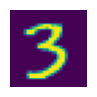

In [12]:
show_image(three_tensors[1])

In [13]:
#Stacking the tensors, converting them to float for certain operations 
#pixel values are expected to be between 0 and 1 (hence division by 255)

stacked_threes = torch.stack(three_tensors).float()/255
stacked_sevens = torch.stack(seven_tensors).float()/255

stacked_threes.shape

torch.Size([6131, 28, 28])

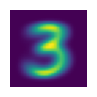

In [14]:
#calculating ideal 3 by taking mean of all images along dimension 0 (this acts as an index)

mean3 = stacked_threes.mean(0)
show_image(mean3);

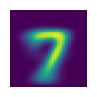

In [15]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

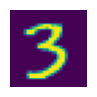

In [16]:
#Calculating the distnace from the ideal and a random sample

a_3 = stacked_threes[1]
show_image(a_3);

In [17]:
#L1 distance or Mean Absolute Difference

dist_3_abs = (a_3 - mean3).abs().mean()
dist_7_abs = (a_3 - mean7).abs().mean()
print('L1 distance of the sample image: \n3 - ',dist_3_abs,'\n7 - ',dist_7_abs)
#L2 distance or Mean Squared Error

dist_3_sqrt = ((a_3 - mean3)**2).mean().sqrt()
dist_7_sqrt = ((a_3 - mean7)**2).mean().sqrt()
print('L2 distance of the sample image: \n3 - ',dist_3_sqrt,'\n7 - ',dist_7_sqrt)

L1 distance of the sample image: 
3 -  tensor(0.1114) 
7 -  tensor(0.1586)
L2 distance of the sample image: 
3 -  tensor(0.2021) 
7 -  tensor(0.3021)


In the both L1 and L2 distances we can see that our sample image is closer to 3 than 7.

In [18]:
#Using PyTorch loss functions 

F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [19]:
#Create a validation set

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

valid_3_tens.shape, valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [20]:
#Function which calculates the distance 

def mnist_distance(a,b):
    return (a-b).abs().mean((-1,-2))

In [21]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)

valid_3_dist, valid_3_dist.shape

(tensor([0.1634, 0.1145, 0.1363,  ..., 0.1105, 0.1111, 0.1640]),
 torch.Size([1010]))

In [22]:
# Check to see if the image is 3

def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [23]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [24]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [25]:
#Calculating the accuracy

accuracy_3s = is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s, accuracy_7s, (accuracy_3s + accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

### Calculating gradients

In [26]:
#Calculating Gradients

#define function
def f(x): return x**2

#Initialize tensor
xt = tensor(3.).requires_grad_()

```requires_grad_()``` method lets PyTorch know that we want to calculate gradients w.r.t to that variable at that value. 

In [27]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

3x3 is 9

In [28]:
#Backpropagation, basically "calculate_grad"
yt.backward()

#View the gradients
xt.grad

tensor(6.)

the derivate of x<sup>2</sup> is 2x<br>
2 x 3 = 6

In [29]:
#repeating above steps but for a vector argument

xt = tensor([3.,4.,10.]).requires_grad_()
print(xt)

#function
def f(x): return (x**2).sum()

yt = f(xt)
print(yt)

#backprop
yt.backward()
print(xt.grad)

tensor([ 3.,  4., 10.], requires_grad=True)
tensor(125., grad_fn=<SumBackward0>)
tensor([ 6.,  8., 20.])


### Stochastic Gradient Descent example

In [30]:
#End to end SGD example

time = torch.arange(0,20).float();
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

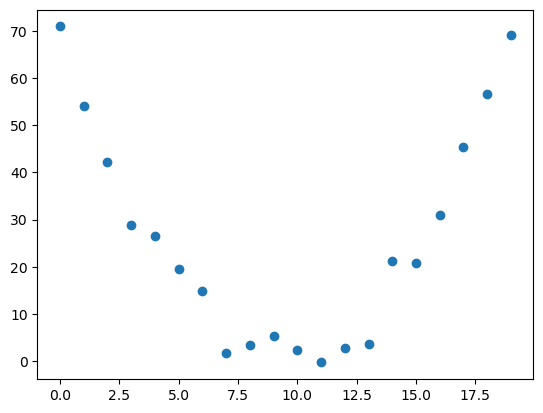

In [31]:
speed = torch.randn(20)*3 + 0.75*(time - 9.5)**2 + 1
plt.scatter(time,speed);

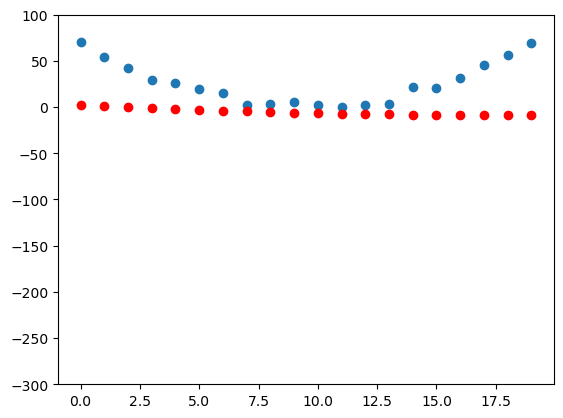

In [32]:
#function assumption 
def f(t, params):
    a,b,c = params
    return a*(t**2) + b*t + c

#loss function
def mse(preds, targets):
    return ((preds - targets)**2).mean()

#STEP 1 - Initialize the parameters
params = torch.randn(3).requires_grad_()

#STEP 2 - Calculate the predictions
preds = f(time, params)

def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

show_preds(preds)

In [33]:
#STEP 3 - Calculate the loss
loss = mse(preds, speed)
loss

tensor(1455.1135, grad_fn=<MeanBackward0>)

In [34]:
#STEP 4 - Calculate the gradients
loss.backward()
print(params.grad)

#Multiply by 1e-5 (learning rate)
params.grad * 1e-5
print(params)



tensor([-9620.5957,  -626.4260,   -62.3986])
tensor([ 0.0319, -1.1509,  1.8131], requires_grad=True)


In [35]:
#STEP 5 - Step the weights
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

tensor(788.1776, grad_fn=<MeanBackward0>)


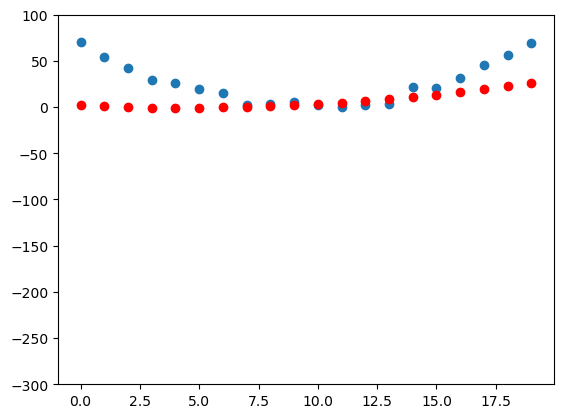

In [36]:
#After 1 step
preds = f(time, params)
print(mse(preds, speed))

show_preds(preds)

In [37]:
#Create a function to apply one step

def apply_step(params, show_loss=True):
    preds = f(time, params)
    loss = mse(speed, preds)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if show_loss: print(loss.item())
    return preds

In [38]:
#STEP 6 - Repeat the process 
for i in range(10): apply_step(params)

788.1776123046875
661.9689331054688
638.0824584960938
633.5584716796875
632.6986083984375
632.5318603515625
632.4963989257812
632.4857788085938
632.4797973632812
632.4747314453125


In [39]:
#STEP 7 - STOP

We have arbitrarily decided to stop after 10 epochs but in reality we would watch the training and validation losses to decide when we stop.

### MNIST Example

In [44]:
#shape before
print(stacked_threes.shape)

#Convert from a rank 3 matrix to rank 2 matrix
train_x = torch.cat([stacked_threes,stacked_sevens]).view(-1,28*28)

#shape after
print(train_x.shape)

torch.Size([6131, 28, 28])
torch.Size([12396, 784])


In [45]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_y.shape

torch.Size([12396, 1])

In [46]:
#PyTorch requires the data to be a tuple 

dset = list(zip(train_x, train_y))
x,y = dset[0]
x.shape, y

(torch.Size([784]), tensor([1]))

In [48]:
#Repeat the same operations for the validation set

valid_x = torch.cat([valid_3_tens,valid_7_tens]).view(-1,28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset =list(zip(valid_x, valid_y))

In [49]:
#Intialize random weights for every pixel

def init_params(size,std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [50]:
#weights
weights = init_params((28*28,1))

#bias
bias = init_params(1)

In [51]:
(train_x[0]*weights.T).sum() + bias

tensor([6.9925], grad_fn=<AddBackward0>)

In [52]:
#Matrix multiplication function

def linear1(xb):
    return xb@weights + bias

preds = linear1(train_x)
preds

tensor([[6.9925],
        [1.5577],
        [7.6242],
        ...,
        [7.5489],
        [1.0443],
        [1.5702]], grad_fn=<AddBackward0>)

In [53]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [55]:
corrects.float().mean().item()

0.4958857595920563

In [60]:
#MNIST Loss function 

# def mnist_loss(predictions, targets):
#     return torch.where(targets==1, 1 - predictions, predictions).mean()

In [61]:
#example 

trgts = tensor([1,0,1])
prds = tensor([0.9,0.4,0.2])

torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

Higher the accuracy of the prediction ,lower the loss.

In [62]:
mnist_loss(prds, trgts)

tensor(0.4333)

Our loss assumes that all the values are between 0 and 1. We can use sigmoid function. 

In [75]:
#new mnist function with sigmoid function

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### Putting it all together

In [88]:
#Re-Initialize the parameters
weights = init_params((28*28,1))
bias = init_params(1)

In [89]:
#Create a DataLoader

dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [90]:
#same for the validation set

valid_dl = DataLoader(valid_dset, batch_size=256)

In [91]:
#Creating a Mini-Batch of size 4 for testing

batch  = train_x[:4]
batch.shape

torch.Size([4, 784])

In [92]:
preds = linear1(batch)
preds

tensor([[ -9.4304],
        [ -3.8211],
        [-14.7723],
        [-12.9601]], grad_fn=<AddBackward0>)

In [93]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.9946, grad_fn=<MeanBackward0>)

In [94]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-0.0007), tensor([-0.0053]))

In [96]:
#Putting it all in one function

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [97]:
#testing the function 

calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(), bias.grad

(tensor(-0.0015), tensor([-0.0105]))

In [98]:
#Change the gradients to 0

weights.grad.zero_()
bias.grad.zero_();

In [99]:
#Update the weights and biases 

def train_epoch(model, lr, params):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [100]:
#Calculate accuracy 

(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [101]:
#Calculate batch accuracy

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [102]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.)

In [103]:
#validate the epoch

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [104]:
validate_epoch(linear1)

0.5585

In [107]:
#Fix the learning rate

lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.7114

In [108]:

for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')


0.8647 0.9198 0.9408 0.9491 0.955 0.9589 0.9618 0.9657 0.9672 0.9696 0.9726 0.974 0.975 0.9755 0.9765 0.977 0.9779 0.9779 0.9784 0.9784 